# FindMyWhale Localization Demo Notebook

## Overview

This notebook accesses data via 


## Table of Contents





In [1]:
# ------------------------------------------------- #
#                      MODULES                      #

# General Modules
import os
import sys
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(".."))

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#
from findmywhale import data_collect

#                                                   #
# ------------------------------------------------- #

In [2]:
# Build HLS Metadata Lookup
hls_lookup = data_collect.get_hls_folders(bucket_name="audio-orcasound-net")

In [3]:
hls_lookup["DATE"] = hls_lookup["DATETIME"].dt.date.astype(str)
hls_lookup["VALUE"] = 1

hls_lookup_pvt = (
    pd.pivot_table(hls_lookup, index="LOCATION", columns="DATE", values="VALUE")
    .fillna(0)
    .astype(int)
)

In [ ]:
hls_lookup_pvt = (
    hls_lookup_pvt.unstack().reset_index().rename(columns={0: "AVAILABILITY"})
)

In [27]:
hls_lookup_pvt

,DATE,LOCATION,AVAILABILITY
0,2018-10-10,rpi_bush_point,1
1,2018-10-10,rpi_mast_center,0
2,2018-10-10,rpi_north_sjc,0
3,2018-10-10,rpi_orcasound_lab,0
4,2018-10-10,rpi_point_robinson,0
...,...,...,...
17299,2025-07-16,rpi_north_sjc,1
17300,2025-07-16,rpi_orcasound_lab,0
17301,2025-07-16,rpi_point_robinson,1
17302,2025-07-16,rpi_port_townsend,1


In [54]:
df_year = hls_lookup_pvt[hls_lookup_pvt["YEAR"] == year].reset_index(drop=True)

In [ ]:
tmp = pd.pivot_table(df_year, index="LOCATION", columns="DATE", values="AVAILABILITY")

/var/folders/p8/19qwfgfd1b1cn30h8qtz26k00000gn/T/ipykernel_24705/2846758526.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p8/19qwfgfd1b1cn30h8qtz26k00000gn/T/ipykernel_24705/2846758526.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/p8/19qwfgfd1b1cn30h8qtz26k00000gn/T/ipykernel_24705/2846758526.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

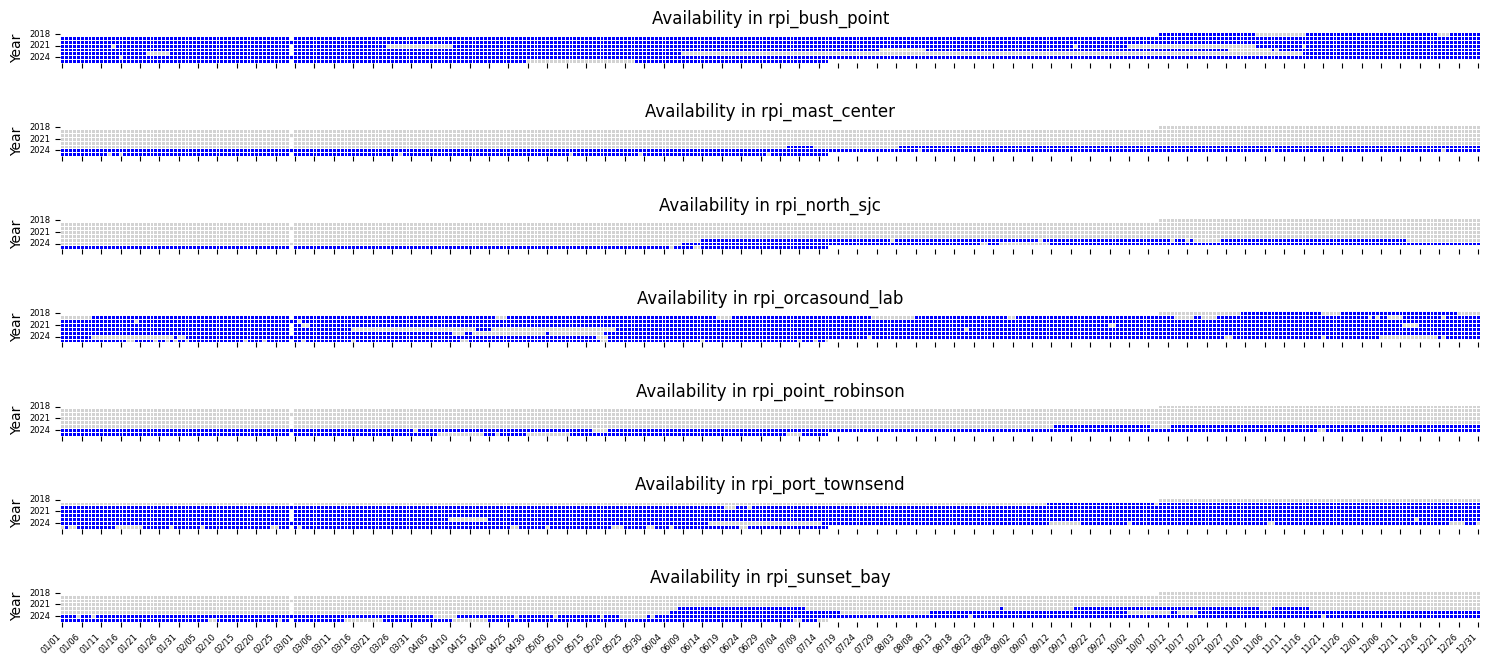

In [ ]:
# Extract year for grouping
hls_lookup_pvt["YEAR"] = pd.to_datetime(hls_lookup_pvt["DATE"]).dt.year

locations = sorted(hls_lookup_pvt["LOCATION"].unique())
n_locs = len(locations)

# Set up matplotlib subplots: one row per year, 1 column
fig, axes = plt.subplots(n_locs, 1, figsize=(15, 1 * n_locs), sharex=True)

if n_locs == 1:
    axes = [axes]  # Make iterable if only one subplot

for ax, location in zip(axes, locations):
    df_year = hls_lookup_pvt[hls_lookup_pvt["LOCATION"] == location]
    df_year["DATE"] = df_year["DATE"].str[5:].str.replace("-", "/")

    # Pivot to matrix: rows=LOCATION, columns=DATE, values=AVAILABILITY
    heatmap_data = df_year.pivot(index="YEAR", columns="DATE", values="AVAILABILITY")

    # Sort columns so dates go left to right
    heatmap_data = heatmap_data.sort_index(axis=1)

    # Plot seaborn heatmap on the axis
    sns.heatmap(
        heatmap_data,
        cmap=["lightgray", "blue"],  # Binary colors, lightgray=0, green=1
        cbar=False,  # ax == axes[-1],          # Show colorbar only on last plot
        ax=ax,
        linewidths=0.5,
        linecolor="white",
        square=True,
        vmin=0,
        vmax=1,
        # cbar_kws={'label': 'Availability'}
    )

    ax.set_title(f"Availability in {location}")
    ax.set_xlabel("")
    ax.set_ylabel("Year")
    ax.tick_params(axis="x", labelsize=6)
    ax.tick_params(axis="y", labelsize=6)

# Rotate date labels on the bottom plot only
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [74]:
df_year

,DATE,LOCATION,AVAILABILITY,YEAR
6,2018-10-10,rpi_sunset_bay,0,2018
13,2018-10-11,rpi_sunset_bay,0,2018
20,2018-10-12,rpi_sunset_bay,0,2018
27,2018-10-13,rpi_sunset_bay,0,2018
34,2018-10-14,rpi_sunset_bay,0,2018
...,...,...,...,...
17275,2025-07-12,rpi_sunset_bay,1,2025
17282,2025-07-13,rpi_sunset_bay,1,2025
17289,2025-07-14,rpi_sunset_bay,0,2025
17296,2025-07-15,rpi_sunset_bay,0,2025
